In [21]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time
import math
from multiprocessing import Process, Manager

array_of_img = [] # Store all the image data
# Read directory function
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)

def compute_Hessian_matrix(array):
    center = array[1, 1, 1]
    dxx = array[1, 1, 2] - 2 * center + array[1, 1, 0]
    dyy = array[1, 2, 1] - 2 * center + array[1, 0, 1]
    dss = array[2, 1, 1] - 2 * center + array[0, 1, 1]
    dxy = 0.25 * (array[1, 2, 2] - array[1, 2, 0] - array[1, 0, 2] + array[1, 0, 0])
    dxs = 0.25 * (array[2, 1, 2] - array[2, 1, 0] - array[0, 1, 2] + array[0, 1, 0])
    dys = 0.25 * (array[2, 2, 1] - array[2, 0, 1] - array[0, 2, 1] + array[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

def compute_Gradient(array):
    
    dx = 0.5 * (array[1, 1, 2] - array[1, 1, 0])
    dy = 0.5 * (array[1, 2, 1] - array[1, 0, 1])
    ds = 0.5 * (array[2, 1, 1] - array[0, 1, 1])
    return np.array([dx, dy, ds])

        
def keypoint(num ,array, return_dict):
    array_of_keypoint_candidate_1 = []
    for j in range(len(array)): #total number of dog of every img
        tmp_height = []
        for k in range(len(array[j])): #height
            tmp_width = []
            for l in range(len(array[j][k])): #width
                min_value = 1e9
                max_value = -1e9
                edge = False
                for m in range(-1, 2):
                    for n in range(-1, 2):
                        for o in range(-1, 2):
                            if j + m == len(array) or j + m == -1 or k + n == len(array[j]) or k + n == -1 or l + o == len(array[j][k]) or l + o == -1:
                                edge = True
                                continue
                            if array[j+m][k+n][l+o] > max_value:
                                max_value = array[j+m][k+n][l+o]
                            if array[j+m][k+n][l+o] < min_value:
                                min_value = array[j+m][k+n][l+o]
                if edge == False:
                    if min_value == array[j][k][l] or max_value == array[j][k][l]:
                        validate = True
                        D = np.stack([array[j-1][k-1:k+2, l-1:l+2],
                            array[j][k-1:k+2, l-1:l+2],
                            array[j+1][k-1:k+2, l-1:l+2]]).astype('float32') / 255.
                        gradient = compute_Gradient(np.array(D).astype('float32') / 255.)
                        hessian = compute_Hessian_matrix(np.array(D).astype('float32') / 255.)
                        extremum_update = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]
                        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
                            validate = False
                        H = hessian[:2][:2]
                        Tr_of_H = H[0][0] + H[1][1]
                        Det_of_H = H[0][0] * H[1][1] - (H[0][1] ** 2)
                        if (Tr_of_H ** 2) * 10 > ((10 + 1) ** 2) * Det_of_H or Det_of_H == 0:
                            validate = False
                        if validate == True:
                            print('hi')
                            gx = int(array[j][k][l+1]) - int(array[j][k][l-1])
                            gy = int(array[j][k+1][l]) - int(array[j][k-1][l])
                            magnitude = np.sqrt(gx ** 2 + gy ** 2)
                            theta = np.rad2deg(np.arctan2(gy, gx))
                            tmp_width.append(1)
                            
                        else:
                            tmp_width.append(0)
                    else:
                        tmp_width.append(0)
                else:
                    tmp_width.append(0)
            tmp_height.append(tmp_width)
        array_of_keypoint_candidate_1.append(tmp_height)
    return_dict[num] = array_of_keypoint_candidate_1
        
def SIFT(inputname):
    read_directory(inputname)
    height, width, channels = array_of_img[0].shape
    #Gaussian Blur with 4 resize and 5 blur each
    array_of_resize_img_1 = []
    for i in range(len(array_of_img)):
        array_of_resize_img_1.append(cv2.cvtColor(array_of_img[i], cv2.COLOR_BGR2GRAY))
    array_of_blur_img_1_1 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_1_1.append(cv2.GaussianBlur(array_of_resize_img_1[i], (3, 3), 0))
    array_of_blur_img_1_2 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_1_2.append(cv2.GaussianBlur(array_of_resize_img_1[i], (5, 5), 0))
    array_of_blur_img_1_3 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_1_3.append(cv2.GaussianBlur(array_of_resize_img_1[i], (7, 7), 0))
    array_of_blur_img_1_4 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_1_4.append(cv2.GaussianBlur(array_of_resize_img_1[i], (9, 9), 0))
    array_of_blur_img_1_5 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_1_5.append(cv2.GaussianBlur(array_of_resize_img_1[i], (11, 11), 0))        
    
    array_of_resize_img_2 = []
    for i in range(len(array_of_img)):
        array_of_resize_img_2.append(cv2.resize(array_of_resize_img_1[i], (int(width/2), int(height/2)), interpolation=cv2.INTER_NEAREST))
    array_of_blur_img_2_1 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_2_1.append(cv2.GaussianBlur(array_of_resize_img_2[i], (3, 3), 0))
    array_of_blur_img_2_2 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_2_2.append(cv2.GaussianBlur(array_of_resize_img_2[i], (5, 5), 0))
    array_of_blur_img_2_3 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_2_3.append(cv2.GaussianBlur(array_of_resize_img_2[i], (7, 7), 0))
    array_of_blur_img_2_4 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_2_4.append(cv2.GaussianBlur(array_of_resize_img_2[i], (9, 9), 0))
    array_of_blur_img_2_5 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_2_5.append(cv2.GaussianBlur(array_of_resize_img_2[i], (11, 11), 0))
    
    array_of_resize_img_4 = []
    for i in range(len(array_of_img)):
        array_of_resize_img_4.append(cv2.resize(array_of_resize_img_1[i], (int(width/4), int(height/4)), interpolation=cv2.INTER_NEAREST))
    array_of_blur_img_4_1 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_4_1.append(cv2.GaussianBlur(array_of_resize_img_4[i], (3, 3), 0))
    array_of_blur_img_4_2 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_4_2.append(cv2.GaussianBlur(array_of_resize_img_4[i], (5, 5), 0))
    array_of_blur_img_4_3 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_4_3.append(cv2.GaussianBlur(array_of_resize_img_4[i], (7, 7), 0))
    array_of_blur_img_4_4 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_4_4.append(cv2.GaussianBlur(array_of_resize_img_4[i], (9, 9), 0))
    array_of_blur_img_4_5 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_4_5.append(cv2.GaussianBlur(array_of_resize_img_4[i], (11, 11), 0))
    
    array_of_resize_img_8 = []
    for i in range(len(array_of_img)):
        array_of_resize_img_8.append(cv2.resize(array_of_resize_img_1[i], (int(width/8), int(height/8)), interpolation=cv2.INTER_NEAREST))
    array_of_blur_img_8_1 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_8_1.append(cv2.GaussianBlur(array_of_resize_img_8[i], (3, 3), 0))
    array_of_blur_img_8_2 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_8_2.append(cv2.GaussianBlur(array_of_resize_img_8[i], (5, 5), 0))
    array_of_blur_img_8_3 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_8_3.append(cv2.GaussianBlur(array_of_resize_img_8[i], (7, 7), 0))
    array_of_blur_img_8_4 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_8_4.append(cv2.GaussianBlur(array_of_resize_img_8[i], (9, 9), 0))
    array_of_blur_img_8_5 = []
    for i in range(len(array_of_img)):
        array_of_blur_img_8_5.append(cv2.GaussianBlur(array_of_resize_img_8[i], (11, 11), 0))
    # Difference of Gaussians
    array_of_dog_1 = []
    for i in range(len(array_of_img)):
        tmp = []
        tmp.append(array_of_blur_img_1_2[i] - array_of_blur_img_1_1[i])
        tmp.append(array_of_blur_img_1_3[i] - array_of_blur_img_1_2[i])
        tmp.append(array_of_blur_img_1_4[i] - array_of_blur_img_1_3[i])
        tmp.append(array_of_blur_img_1_5[i] - array_of_blur_img_1_4[i])
        array_of_dog_1.append(tmp)
    array_of_dog_2 = []
    for i in range(len(array_of_img)):
        tmp = []
        tmp.append(array_of_blur_img_2_2[i] - array_of_blur_img_2_1[i])
        tmp.append(array_of_blur_img_2_3[i] - array_of_blur_img_2_2[i])
        tmp.append(array_of_blur_img_2_4[i] - array_of_blur_img_2_3[i])
        tmp.append(array_of_blur_img_2_5[i] - array_of_blur_img_2_4[i])
        array_of_dog_2.append(tmp)
    array_of_dog_4 = []
    for i in range(len(array_of_img)):
        tmp = []
        tmp.append(array_of_blur_img_4_2[i] - array_of_blur_img_4_1[i])
        tmp.append(array_of_blur_img_4_3[i] - array_of_blur_img_4_2[i])
        tmp.append(array_of_blur_img_4_4[i] - array_of_blur_img_4_3[i])
        tmp.append(array_of_blur_img_4_5[i] - array_of_blur_img_4_4[i])
        array_of_dog_4.append(tmp)
    array_of_dog_8 = []
    for i in range(len(array_of_img)):
        tmp = []
        tmp.append(array_of_blur_img_8_2[i] - array_of_blur_img_8_1[i])
        tmp.append(array_of_blur_img_8_3[i] - array_of_blur_img_8_2[i])
        tmp.append(array_of_blur_img_8_4[i] - array_of_blur_img_8_3[i])
        tmp.append(array_of_blur_img_8_5[i] - array_of_blur_img_8_4[i])
        array_of_dog_8.append(tmp)
    
    #keypoint candidate
    start_time = time.time()
    manager = Manager()
    return_dict = manager.dict()
    process = []
    for i in range(len(array_of_dog_1)):
        p = Process(target=keypoint, args=(i, array_of_dog_1[i], return_dict))
        process.append(p)
        process[i].start()
        break
    for i in range(len(process)):
        process[i].join()
        break
    array_of_keypoint_candidate_1 = return_dict.values()
    
    manager = Manager()
    return_dict = manager.dict()
    process = []
    for i in range(len(array_of_dog_2)):
        p = Process(target=keypoint, args=(i, array_of_dog_2[i], return_dict))
        process.append(p)
        process[i].start()
    for i in range(len(process)):
        process[i].join()
    array_of_keypoint_candidate_2 = return_dict.values()
    
    manager = Manager()
    return_dict = manager.dict()
    process = []
    for i in range(len(array_of_dog_4)):
        p = Process(target=keypoint, args=(i, array_of_dog_4[i], return_dict))
        process.append(p)
        process[i].start()
    for i in range(len(process)):
        process[i].join()
    array_of_keypoint_candidate_4 = return_dict.values()
    
    manager = Manager()
    return_dict = manager.dict()
    process = []
    for i in range(len(array_of_dog_8)):
        p = Process(target=keypoint, args=(i, array_of_dog_8[i], return_dict))
        process.append(p)
        process[i].start()
    for i in range(len(process)):
        process[i].join()
    array_of_keypoint_candidate_8 = return_dict.values()
    print(array_of_keypoint_candidate_1.count(1))
    print((start_time - time.time()) /60)
    imageoutput = array_of_img[0]
    array_of_img.clear()
    return imageoutput

In [ ]:
f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
while(dirname):   
    imageout=SIFT(dirname)
    plt.figure()
    plt.imshow(imageout)
    cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
h

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
h

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi

In [85]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time
import math
from multiprocessing import Process, Manager

array_of_img = [] # Store all the image data
# Read directory function
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

def SIFT(inputname):
    read_directory(inputname)
    array_of_gray_img = []
    for i in range(len(array_of_img)):
        array_of_gray_img.append(cv2.cvtColor(array_of_img[i], cv2.COLOR_BGR2GRAY))
    #keypoint and descriptor
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    for i in range(1, len(array_of_img)):
        keypoint_1, descriptor_1 = sift.detectAndCompute(array_of_img[0], None)
        keypoint_2, descriptor_2 = sift.detectAndCompute(array_of_img[i], None)
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
        matches = bf.match(descriptor_1, descriptor_2)
        matches =sorted(matches, key=lambda x:x.distance)

        src_pts = np.float32([keypoint_1[m.queryIdx].pt for m in matches[:50]]).reshape(-1,1,2)
        dst_pts = np.float32([keypoint_2[m.trainIdx].pt for m in matches[:50]]).reshape(-1,1,2)
        M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        tmp = cv2.warpPerspective(array_of_img[i], M, (array_of_img[0].shape[1] + array_of_img[i].shape[1], array_of_img[0].shape[0]))
        tmp[0:array_of_img[0].shape[0],0:array_of_img[0].shape[1]] = array_of_img[0]
        array_of_img[0] = trim(tmp)
    
    imageoutput = array_of_img[0]
    array_of_img.clear()
    return imageoutput

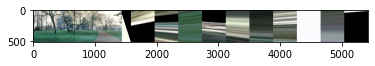

In [86]:
f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
while(dirname):   
    imageout=SIFT(dirname)
    plt.figure()
    plt.imshow(imageout)
    cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()